<div style="text-align: center">
<b><font size=6>ChEn 3603 Homework 11 Problem 1
    </font></b>
</div>

<div class="alert alert-block alert-danger">

&copy; 2020 This material is copyright protected. Distributing this material in any form without written permission from Professor Sutherland is prohibited and may result in academic discipline.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve

In [2]:
# Load the Txy data
data = pd.read_csv('Txy.csv')
Teq = data['T'].values
xeq = data['x'].values
yeq = data['y'].values

In [3]:
x0 = 0.7   # initial charge composition
W0 = 10    # initial charge (kmol)
D = 10*1e-3*60   # boilup rate, (kmol/hr)

# Part 1 - determine $\bar{K}$ and $\bar{\alpha}$

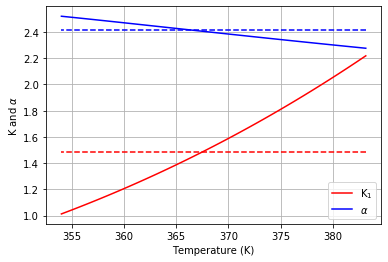

Kavg = 1.48
alpha_avg = 2.41


In [4]:
# don't include the 0 and 1 values since those blow up the K-values.
i = np.where( (xeq>0) & (xeq<1.0) )

K1 = yeq[i]/xeq[i]

K_avg = np.mean(K1)

K2 = ( 1 - yeq[i] ) / ( 1 - xeq[i] )

alpha = K1 / K2
alpha_avg = np.mean(alpha)

plt.plot(Teq[i],K1,'r-',label='K$_1$')
# plt.plot(Teq[i],K2,label='K$_2$')
plt.plot(Teq[i],alpha,'b-',label=r'$\alpha$')
plt.plot(Teq[i],alpha_avg*np.ones_like(alpha),'b--')
plt.plot(Teq[i],K_avg*np.ones_like(K1),'r--')
plt.xlabel('Temperature (K)')
plt.ylabel(r'K and $\alpha$')
plt.legend()
plt.grid()
plt.show()

print('Kavg = {:.2f}'.format(K_avg))
print('alpha_avg = {:.2f}'.format(alpha_avg))

----
# Part 2

We are asked to find several quantities. 

 1. The residue composition will be different for each of the solution approaches, so we'll cover that separately below.
 1. The average vapor composition is:
   \begin{align}
      y^\mathrm{avg} &= \frac{x_0W_0 - xW}{W_0 -W} \\
          &= \frac{x_0 - x\frac{W}{W_0}}{1-\frac{W}{W_0}}        \label{eq:yavg}
    \end{align}
 1. To determine the temperature of the still, we can interpolate the _Txy_ data given the composition of the residue.
 1. Since $D$ is constant, the time required is $$t = \frac{W_0 - W}{D}$$

In [11]:
W_W0_end = 0.5  # fraction remaining in the still

## Part 2a: constant $K$

If $K$ is constant, then from the class notes we have
\begin{equation}
    \frac{1}{K-1} \ln\frac{x}{x_0} = \ln\frac{W}{W_0}
\end{equation}
Solving for $x$, we find:
\begin{equation}
    x = x_0 \exp\left[ (K-1) \ln\frac{W}{W_0} \right]
\end{equation}

In [12]:
def y_avg( x0, x, W_W0 ):
    return ( x0 - x*W_W0 ) / ( 1 - W_W0 )

def print_results(x,y):
    print('\n\nLight key mole fractions:')
    print('\tResidue      : {:.3f}'.format(x))
    print('\tAverage vapor: {:.3f}\n'.format(y))
    print('Residue temperature: {:.0f} K\n'.format(np.interp(x,xeq,Teq)) )
    print('Time required: {:.2f} hours\n\n'.format((W0 - W_W0_end*W0)/D) )
    
x_end = x0 * np.exp( (K_avg - 1.0)*np.log(W_W0_end) )

print_results( x_end, y_avg(x0,x_end,W_W0_end) )



Light key mole fractions:
	Residue      : 0.501
	Average vapor: 0.899

Residue temperature: 366 K

Time required: 8.33 hours




# Part 2b: constant-$\alpha$

If relative volatility is constant, we know
\begin{equation}
    \ln \left( \frac{W_0}{W} \right) = \frac{1}{\alpha-1} \left[ \ln\frac{x_0}{x} + \alpha\ln\frac{1-x}{1-x_0} \right]
\end{equation}
This equation isn't easily inverted to find $x$ so we will solve it numerically.

In [6]:
res = lambda x: np.log(1/W_W0_end) - 1/(alpha_avg-1) * ( np.log(x0/x) + alpha_avg * np.log( (1-x)/(1-x0) ) )

x_end = fsolve( res, x_end )
x_end = x_end[0]

print_results(x_end,y_avg(x0,x_end,W_W0_end))



Light key mole fractions:
	Residue      : 0.583
	Average vapor: 0.817

Residue temperature: 363 K

Time required: 8.33 hours




# Part 2c: _Txy_ data

We know that 
$$
    \int_{x_{0}}^{x_{F}}\frac{dx}{y-x}=\ln\frac{W}{W_{0}} 
$$
and we can use the data given to obtain $y(x)$. 
Here, we know $\frac{W}{W_{0}}$ but we don't know the final composition in the still (the lower limit on the integral). 
We can formulate this as a nonlinear equation:
\begin{equation}
    r(x_{F}) = \ln \frac{W}{W_{0}} - \int_{x_{0}}^{x_{F}} \frac{dx}{y-x} 
\end{equation}
which we want to solve for $x$ such that $r(x_{F})=0$. We can use an initial guess of $0<x_{F}\le x_{0}$ and use `scipy.fsolve` function to solve the problem.

In [7]:
# build functions to interpolate the equilibrium data
eval_y = lambda x: np.interp(x,xeq,yeq)
eval_T = lambda x: np.interp(x,xeq,Teq)

# function to calculate the integrand
integrand_fun = lambda x: 1 / ( eval_y(x) - x ) 

# function to populate x values on the interval [x0,lo]
xvals  = lambda xlo: np.linspace(x0,xlo,10)

# the residual function that we want to solve
def resfun(xlovals):
    scalar_input = False
    
    # make this function work for scalar or array inputs.
    # For scalars, we detect that and then convert them to arrays
    xlovals = np.asarray(xlovals)
    if xlovals.ndim==0:
        scalar_input = True
        xlovals = xlovals[None] # make into a 1D array

    results = np.zeros_like(xlovals)
    for i in range(len(xlovals)):
        x = xvals( xlovals[i] )
        results[i] = np.log(W_W0_end) - np.trapz( integrand_fun(x), x )
    
    if scalar_input:
        return np.squeeze(results)  # turn back into a scalar
    return results

In [8]:
# we need to determine the lower bound on the integral such that we obtain the desired W/W0.
result = fsolve( resfun, 0.1 )
x_end = result[0]

print_results(x_end,y_avg(x0,x_end,W_W0_end))



Light key mole fractions:
	Residue      : 0.581
	Average vapor: 0.819

Residue temperature: 363 K

Time required: 8.33 hours




----
# Part 3
Here we want to produce plots of $x(t)$ and $y^\mathrm{avg}(t)$ for the constant $K$ and constant $\alpha$ models for $\frac{W}{W_0} = 0.05$.

In [9]:
def time_plotter(W_W0_end):

    W_W0 = np.linspace(0.99,W_W0_end)  # leave out (W/W0=1) to avoid divide-by-zero

    x_K = x0 * np.exp( (K_avg - 1.0)*np.log(W_W0) )

    x_alpha = np.zeros_like(W_W0)

    for i in range(0,len(W_W0)):
        res = lambda x: np.log(1/W_W0[i]) - 1/(alpha_avg-1) * ( np.log(x0/x) + alpha_avg * np.log( (1-x)/(1-x0) ) )
        x_alpha[i] = fsolve( res, x0 )

    t = ( W0 - W_W0*W0 ) / D

    plt.plot(t,x_K,    'r-',label='x - constant K')
    plt.plot(t,x_alpha,'k-',label=r'x - constant $\alpha$')
    plt.plot(t,y_avg(x0,x_K,    W_W0),'r--',label=r'$y^{avg}$ - constant K')
    plt.plot(t,y_avg(x0,x_alpha,W_W0),'k--',label=r'$y^{avg}$ - constant $\alpha$')
    plt.plot(t,W_W0,label=r'$\frac{W}{W_0}$')
    
    plt.xlabel('t (hr)')
    plt.legend()
    plt.ylabel('Mole fractions')
    plt.grid()
    plt.show()

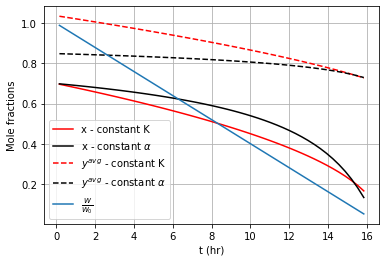

In [10]:
time_plotter( 0.05 )

A few observations:
  * The differences in $y^\mathbf{avg}$ become less pronounced over time.  This is expected since once we boil everything off, $y^\mathbf{avg} = x_0$.
  * The two models produce different shapes for the $x(t)$ curve.  Constant $K$ predicts lower $x$ than constant $\alpha$ early on, but this then switches around 13 hours.